# 05. Machine Learning for music playlists: K-nearest neighbors classification
This is the 5th post of a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
The purpose of the analysis is to detect tracks in my iTunes music library that would suit my fitness practices, which are "cycling", "yoga", and "ballet". To solve that problem I use supervised ML classification techniques. 

The previous posts cover the following steps:
1. [00_Summary](http://localhost:8888/notebooks/00_Summary.ipynb) — Summary of this analysis, its goals and methods, installation notes.
2. [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) — Data gathering and cleaning.
3. [02_Data_visualisation](http://localhost:8888/notebooks/02_Data_Visualisation.ipynb) — Visualisation and overview of data.
4. [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) — Data preprocessing to use it as input for Scikit-learn machine learning algorithms.
5. [04_Novelty_detection](http://localhost:8888/notebooks/04_Novelty_detection.ipynb) — Apply One-Class SVM algorithm to identify matching tracks in the unlabeled dataset.

As a result of previous manipulations I have two tables in HDF5 format: 
* training set contains 88 tracks labeled with one of the three classes: "ballet", "cycling", "yoga". Labels are stored as a pandas Series;
* test set contains 289 tracks labeled as matching the training set and 155 tracks as non-matching. In the [04_Novelty_detection](http://localhost:8888/notebooks/04_Novelty_detection.ipynb) NB I used One-Class SVM to choose tracks in the test set that match training data. As a result, each track was identified either as matching or not.

In this post I apply [k neighbours classification](http://scikit-learn.org/stable/modules/neighbors.html#classification) to assign every track in the matching group one of the classes. 

As a shortcut, in this notebook I import module "data_processing" where I perform steps from the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) and [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) notebooks.  
I start with importing the modules required in the following notebook.

In [174]:
from __future__ import division
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# import my module from the previous notebook
import data_processing as prs

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

# nearest neighbours algorithm
from sklearn import neighbors

### Read in data

In [33]:
# open an hdf5 file
store = pd.HDFStore('music_data.h5')
store

<class 'pandas.io.pytables.HDFStore'>
File path: music_data.h5
/target               series       (shape->[88])                                           
/test_svm             frame_table  (typ->appendable,nrows->444,ncols->12,indexers->[index])
/train_std            frame_table  (typ->appendable,nrows->88,ncols->11,indexers->[index]) 

Both sets are stored as pandas DataFrames. I convert these to numpy arrays because Scikit-Learn algorithms expect a numpy array as input. I also save index in the test set as a column when converting it to a numpy array. Thus it will be easier to identify each track after classification, where I'll be using only tracks labeled as matching. 

Data in both sets were standardized in the pre-processing step.

In [149]:
# get training data (standardized) and convert to numpy array
train_std = prs.convert_df_to_array(store['train_std'])

# get test data (standardized) and convert to numpy array
test_std = prs.convert_df_to_array(store['test_svm'].reset_index())

# set with matching tracks
match_test = test_std[(test_std[:, 12] == 1)]

# target data as numpy array
target = store['target'].values

# list class labels
labels = ['ballet', 'cycling', 'yoga']

In [46]:
print "Data overview: "
print "Train data shape:", train_std.shape
print "Test data shape:", test_std.shape
print "Test data only with matching tracks:", match_test.shape

Data overview: 
Train data shape: (88, 11)
Test data shape: (444, 13)
Test data only with matching tracks: (289, 13)


## K-nearest neighbors classification
Nearest neighbors classification algorithm computes a class for every query point (that is, unlabeled observation) based on a simple majority of class representatives within the nearest labeled neighbors. In Scikit_Learn [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) number of nearest neighbors of each query point — *k* — is specified in model parameters.

The process I use for classification task is as follows:
1. Tune parameters using GridSearchCV.
2. Create and train the model.
3. Estimate model accuracy score.
4. Make predictions and estimate probability.
5. Record the result to the set and DF.
6. Review the results.
7. Apply probability threshold. 

### 1. Tune parameters using GridSearchCV
[GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) performs an exhaustive search over specified parameter values for an estimator. I use it to test the desired range of input parameters, and review the performance of each set of values on a cross-validation basis. 

In [27]:
from sklearn.grid_search import GridSearchCV

# tune parameters
parameter_grid = {'n_neighbors': [3, 5, 7],
                  'weights': ['uniform', 'distance'],
                 'algorithm': ['auto', 'ball_tree', 
                               'kd_tree', 'brute']}

grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), 
                           parameter_grid, cv=6)

grid_search.fit(train_std, target)

# review the result
grid_search.grid_scores_

[mean: 0.81818, std: 0.11593, params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.80682, std: 0.11825, params: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.79545, std: 0.11954, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.79545, std: 0.11328, params: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.82955, std: 0.12676, params: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto'},
 mean: 0.84091, std: 0.12716, params: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto'},
 mean: 0.81818, std: 0.11593, params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree'},
 mean: 0.80682, std: 0.11825, params: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree'},
 mean: 0.79545, std: 0.11954, params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree'},
 mean: 0.79545, std: 0.11328, params: {'n_neighbors': 5, 'weights': 'dis

In [29]:
# sort the results 
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

knn_best_score = grid_search.best_score_
best_params = grid_search.best_params_

# print the winner
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nBest parameters: {1}."
       .format(knn_best_score, 
               best_params
              ))

The best-performing tuning parameters
Best score: 0.840909090909;
Best parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto'}.


### 2. Create and train the model
Next I create a model using the parameters defined by GridSearchCV.

In [47]:
# create the model
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
algorithm = best_params['algorithm']
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, 
                                     weights=weights, 
                                     algorithm=algorithm)

# train the model
knn.fit(train_std, target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='distance')

### 3. Estimate model accuracy score
One of the most important pieces of machine learning is model validation: that is, checking how well the model fits a given dataset. I can not automatically assess the accuracy of predictions made for the test set, because it is non-labeled data. A better way to test a model is to use a hold-out part of the labeled set which doesn't enter the training.  

Scikit-Learn provides a great tool for model validation — [K-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score) module, which splits the data into K chunks and performs K fits, where each chunk gets a turn as the validation set. K is defined by the cv parameter. I use 10-fold cross validation. 

In [150]:
from sklearn.cross_validation import cross_val_score

# calculate model accuracy score
cvs = cross_val_score(knn, train_std, target, 
                    scoring='accuracy', cv=10).mean()

In [153]:
# Build a text report showing the main classification metrics
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
    
predicted = cross_val_predict(knn, train_std, 
                            target, cv=10)

print ("K-neighbors classification model "
       "accuracy score: {:.3f}"
       .format(model_cross_valid(knn, train_std, target)))
print "Model report \n", 
print classification_report(target, predicted, 
                            target_names=labels)

K-neighbors classification model accuracy score: 0.786
Model report 
             precision    recall  f1-score   support

     ballet       0.76      0.74      0.75        34
    cycling       0.84      1.00      0.91        31
       yoga       0.78      0.61      0.68        23

avg / total       0.79      0.80      0.79        88



Let me explain the above numbers. 

The *precision* is the ratio of true positives to the sum of true and false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.  
In this case "cycling" class has the highest precision. That means that the pureness of model prediction for that class is 84% (16% of tracks assigned this class had a different label), whereas for the "ballet" class it equals 76%, which still is pretty high.

The *recall* is the ratio of true positives to the sum of true positives and false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. 
The "cycling" class has the highest possible score. All tracks belonging to that class were identified correctly by the model. The "yoga" class has the lowest ratio. The precision ratio, however, is rather high. That means that just 22% of tracks assigned the "yoga" class had a different label but at the same time 40% of tracks with the "yoga" label were assigned a different class.  

The *F1-score* can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

The *support* is the number of occurrences of each class in y_true. This is the number of tracks in each class. 

The overall accuracy of the model is high. The "cycling" class proves itself as the easiest to predict and the "yoga", on the contrary, has the least accurate predictions.

### 4. Make predictions and estimate probability
Satisfied with the model performance on the training set, I apply it to the test set to make predictions using predict method. 

In [132]:
# make predictions
# exclude index and novelty result
knn_output = knn.predict(match_test[:, 1:12])

Nearest neighbors classifier has predict_proba method that can predict the probability of class membership. For every query point it will calculate the probablity of belonging to each class.

In [130]:
def class_prob(model):
    """Calculate probability for 
    every class and return an array
    with highest probability for each
    track. 
    """
    probability = model.predict_proba(match_test[:, 1:12])
    
    # make a list of highest probabilities
    max_proba = np.asarray([x.max() for x in probability])
    return max_proba[:, None]

In [133]:
# classification probability
knn_prob = class_prob(knn)

### 5. Record the result
I add the model prediction and probability to the matching set and then to the DF. I store the resulting dataframe as a hdf5 file. 

In [136]:
# add the result to the matching set
knn_set = np.concatenate((match_test, knn_output[:, None], knn_prob), 1)

# review the result
print knn_set.shape
print "\nSample of the resulting set: "
knn_set[:3]

(289, 15)

Sample of the resulting set: 


array([[ 0.        , -1.20843788,  0.63488137,  1.25808605, -0.88779748,
        -0.49132844,  0.78719594, -1.1740436 , -0.39262975, -0.74488995,
         0.43101536,  0.57687657,  1.        ,  1.        ,  0.66406856],
       [ 1.        , -0.2793643 , -0.95059729, -0.59717964,  1.12009741,
         1.26151896,  0.17775694, -1.1740436 , -0.80693268,  0.63767235,
        -0.87689333, -0.01472446,  1.        ,  0.        ,  0.83478127],
       [ 2.        ,  0.72038789,  1.90749621, -0.54831972,  1.14486486,
         0.38509526, -0.33955242,  0.85175712, -0.08956489,  0.29581684,
         0.43101536,  1.24591181,  1.        ,  0.        ,  0.53629557]])

In [139]:
# transform the set back into pandas dataframe
def nparray_to_df(data):
    """Transform dataset in numpy array format to a df.
    Return the df.
    """
    # make a list of column names
    li = (['index'] + 
          store['train_std'].columns.tolist() + 
          ['match', 'label', 'prob'])
    
    # transform set into a DF
    df = pd.DataFrame(data, columns=li)
    
    # change column type to integer
    df[['index', 'match', 'label']] = df[['index', 'match', 'label']].astype(int)
    
    # change index to the original index
    df = df.set_index(['index'])

    return df

In [141]:
# make a df for data with KNN results
knn_df = nparray_to_df(knn_set)

# review the result
knn_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,label,prob
index,,,,,,,,,,,,,,
47,-0.54,0.43,-0.00,1.25,0.09,0.42,0.85,0.12,0.12,0.43,0.72,1,1,0.69
324,0.17,0.26,-0.89,-0.91,-0.20,-0.24,0.85,-1.03,-0.84,-0.88,-0.57,1,0,1.00
253,-1.19,1.11,0.91,-0.33,-1.66,0.96,0.85,-0.23,-0.07,0.43,1.36,1,1,1.00


In [143]:
# save in HDF5
knn_df.to_hdf('music_data.h5', 'knn_df', format='table')

### 6. Review the result

In [173]:
def model_summary(df, model, model_name, labels):
    print ("Summary of the {} classifier "
           "performance\n".format(model_name))
    print "Model: "
    print model
    print ("\nModel accuracy score: {:.3f}"
           .format(cvs))
    # drop 'match' column as it's not relevant here
    df = df.drop('match', 1)
    print ("\nNumber of tracks in the test set: {}."
           .format(len(df)))
    for lb in labels:
        print ("Number of tracks assigned to the \"{}\" class: {}, or {:.2%} of all tracks."
               .format(lb, len(df[df['label'] == labels.index(lb)]),
                      (len(df[df['label'] == labels.index(lb)])/len(df))))
    print "\nMean probability for each category"
    grouped = df.groupby(['label'])
    print grouped['prob'].mean()

In [172]:
len(knn_df[knn_df['label'] == labels.index('cycling')])/len(knn_df)

0.5951557093425606

In [175]:
# print the summary
model_summary(knn_df, knn, 'K-Nearest Neighbors', labels)

Summary of the K-Nearest Neighbors classifier performance

Model: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='distance')

Model accuracy score: 0.786

Number of tracks in the test set: 289.
Number of tracks assigned to the "ballet" class: 112, or 38.75% of all tracks.
Number of tracks assigned to the "cycling" class: 172, or 59.52% of all tracks.
Number of tracks assigned to the "yoga" class: 5, or 1.73% of all tracks.

Mean probability for each category
label
0   0.72
1   0.83
2   0.64
Name: prob, dtype: float64


The "cycling" class has the highest mean probability, which means that on average tracks are assigned this class with 83% certainty. At the same time this is the most popular class — almost 60% of all tracks in the test set are assigned the "cycling" class. 

The "ballet" class is doing alright. Almost 40% of all tracks are assigned this class label with 72% certainty on average. 

The "yoga" class has the fewest representatives in the test set. Only 5 tracks were assigned this class label. The mean probability is the lowest among the three classes.  

### 6. Apply probability threshold
In my playlists I want to keep only tracks with high probability of class membership. To decide on the threshold for  probability estimate I plot number of tracks in each class with a threshold varying from 0 to 100%. 

In [186]:
def prob_with_threshold(df, threshold):
    """Returns a df with class probability
    higher than a threshold.
    """
    # drop 'match' column as it's not relevant here
    df = df.drop('match', 1)
    
    prob_thres = df[df['prob'] >= threshold]
    return prob_thres

def sum_category(df, index):
    """Returns number of tracks in a category
    """
    category_size = len(df[df['label'] == index])
    return category_size

#### Make a plot

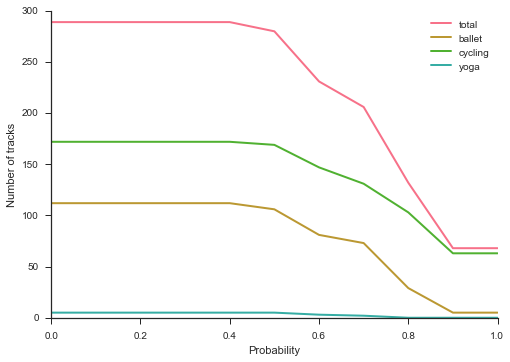

In [188]:
# threshold values
xs = list(a / 10.0 for a in range(11))

# all classes
total = [len(prob_with_threshold(knn_df, i)) for i in xs]
line_total = plt.plot(xs, total, linewidth=2, label='total')

for lb in labels:
    lb_sum = [sum_category(prob_with_threshold(knn_df, i), 
                             labels.index(lb)) for i in xs]
    line_lb = plt.plot(xs, lb_sum, linewidth=2, label=lb)

plt.ylabel('Number of tracks')
plt.xlabel('Probability')
plt.legend()
sns.despine()
plt.show()

Looking at the plot, I'd say that 0.7 is a good value for the probability threshold. It filters out some tracks in each class, eliminating tracks with lower certainty of class membership and, thus, making the playlists more accurate. Setting the value to 0.8 and higher leaves the "yoga" class without any tracks at all and excludes big part of tracks in two other classes. 

I apply the 0.7 probability threshold to data and review the result.

In [192]:
def summary_of_prob_with_thres(df, threshold, labels):
    df_prob = prob_with_threshold(knn_df, 0.7)
    print ("Total number of tracks to classify: {}."
           .format(len(df)))
    print ("Number of tracks with {} probability "
          "of class membership: {}."
          .format(threshold, len(df_prob)))
    print "Among which..."
    for lb in labels:
        print ("...assigned the \"{}\" class: {} ({} without the threshold)."
               .format(lb, len(df_prob[df_prob['label'] == labels.index(lb)]),
                      len(df[df['label'] == labels.index(lb)])))
    print "\nMean probability for each class"
    grouped = df_prob.groupby(['label'])
    print grouped['prob'].mean()

In [193]:
# print summary 
summary_of_prob_with_thres(knn_df, 0.7, labels)

Total number of tracks to classify: 289.
Number of tracks with 0.7 probability of class membership: 206.
Among which...
...assigned the "ballet" class: 73 (112 without the threshold).
...assigned the "cycling" class: 131 (172 without the threshold).
...assigned the "yoga" class: 2 (5 without the threshold).

Mean probability for each class
label
0   0.80
1   0.90
2   0.72
Name: prob, dtype: float64


### Summary
In this notebook I applied k-neighbors classification tecnique to identify class membership of every track in the matching group and assign a class label. 